In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
import time


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))



logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [2]:
def generate_index_shapes(shape: int) -> list[tuple[int, ...]]:
    return [(1,) * i + (shape[i],) + (1,) * (len(shape) - i - 1) for i in range(len(shape))]


def generate_tile_shapes(shape: tuple[int, ...]) -> tuple[tuple[int, ...]]:
    return tuple(tuple(1 if j == i else shape[j] for j in range(len(shape))) for i in range(len(shape)))


def create_index_matrix(shape: tuple[int, ...]) -> tuple[np.ndarray, ...]:
    # Calculate the center indices
    center = [dim//2 for dim in shape]
    indices = [
        np.arange(dim).reshape(*index_shape) - center
        for dim, center, index_shape in zip(shape, center, generate_index_shapes(shape))
    ]

    return tuple(
        np.tile(
            index, tile_shape
        )
        for index, tile_shape in zip(indices, generate_tile_shapes(shape))
    )


def select_data(data: np.ndarray, indices: np.ndarray) -> np.ndarray:
    # Check dimensions
    if isinstance(indices, (tuple, list)):
        indices_ndim = len(indices)
        indices = [*indices]
    else:
        indices_ndim = indices.ndim
        indices = [indices]

    if indices_ndim >= data.ndim:
        # Directly use indices for selection
        return data[*indices]
    else:
        # Prepare a tuple for advanced indexing
        idx = [slice(None)] * (data.ndim - indices_ndim) + indices
        return data[tuple(idx)]

In [3]:
def get_hd_cue(
    angle: float,
    n_neurons: int,
    max_amplitude: float = 1,
    angular_sigma: float = .1667
) -> np.ndarray:
    # Create a linear space from 0 to 2*pi with n elements
    x = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)

    # Ensure the angle is within the range [0, 2*pi]
    angle = angle % (2 * np.pi)

    # Calculate the distance on the ring between each point and the peak angle
    # This takes into account the wrap-around effect
    distance = np.minimum(np.abs(x - angle), 2 * np.pi - np.abs(x - angle))

    # Create a Gaussian distribution centered at the specified angle with wrap-around
    gaussian = max_amplitude * np.exp(-(distance**2) / (2 * angular_sigma**2))

    return gaussian


def create_ricker_matrix(m, n, a=None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if a is None:
        a = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Ricker wavelet function
    for i in range(m):
        for j in range(n):
            # Calculate distances from the center
            x = i - center_x
            y = j - center_y
            # Calculate the Ricker wavelet value
            factor = (x**2 + y**2) / a**2
            matrix[i, j] = (1 - factor) * np.exp(-factor / 2)

    return matrix


def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    # x = np.linspace(0, 1, n_neurons, endpoint=False)
    # distance = np.minimum(np.abs(x - center), 2 * np.pi - np.abs(x - center))
    # gaussian = amplitude*np.exp(-(distance**2) / (2 * sigma**2))

    return get_hd_cue(
        center*2*np.pi,
        n_neurons,
        amplitude,
        angular_sigma=sigma*2*np.pi
    )

2024-06-08 15:55:13 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-08 15:55:13 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-08 15:55:13 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-08 15:55:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2024-06-08 15:55:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-06-08 15:55:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Proje

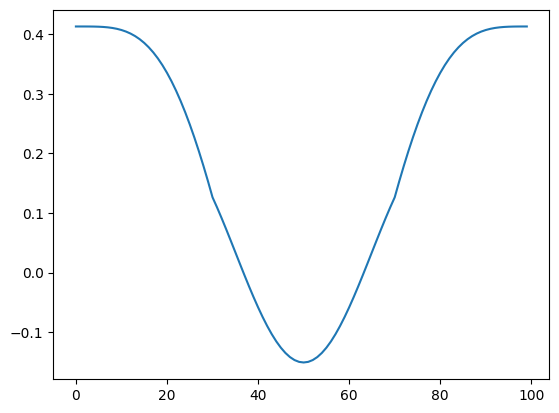

In [4]:
plt.plot(
    get_gaussian_kernel(
        100,
        center=0.2,
        sigma=0.2
    ) - .4 + get_gaussian_kernel(
        100,
        center=0.8,
        sigma=0.2
    ) - .4
)

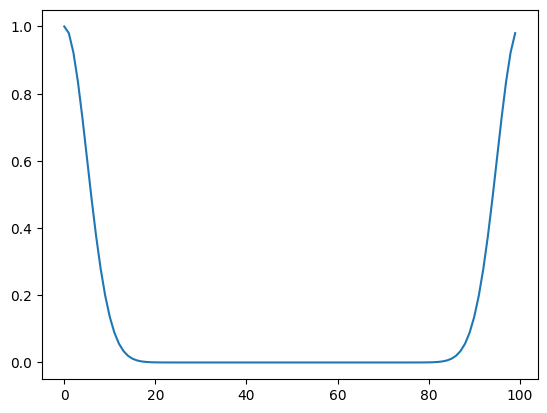

In [5]:
plt.plot(
    get_gaussian_kernel(
        100,
        center=0.,
        sigma=0.05,
    )
)

for i, (indices) in enumerate(zip(*np.nonzero(self.kernel))):
            # if len(indices) > 1 and all(x == indices[0] for x in indices):
            #     continue
            # if i == -2:
            #     continue
            other += self[indices]

In [6]:
import re
from typing import Callable

def wrap_indices(indices: tuple[int, ...], shape: tuple[int, ...]) -> tuple[int, ...]:
    if len(indices) != len(shape):
        raise ValueError('Indices and shape must have the same length')
    return tuple((((i % s) + s) % s for i, s in zip(indices, shape)))


class IteratorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.ranges = [range(dim) for dim in shape]
        self.current = [0] * len(shape)  # Initialize current index to start of each dimension
        self.started = False  # To handle the first increment

    def __iter__(self):
        return self

    def __next__(self):
        if not self.started:
            self.started = True
            if all(size == 0 for size in self.shape):  # Handle empty shape
                raise StopIteration
            return tuple(self.current)  # Return the first index if not started

        for i in range(len(self.shape) - 1, -1, -1):
            if self.current[i] < self.shape[i] - 1:
                self.current[i] += 1
                for j in range(i + 1, len(self.shape)):
                    self.current[j] = 0
                return tuple(self.current)
            elif i == 0:
                raise StopIteration
            self.current[i] = 0  # Reset current index at dimension i and continue


class WrapperIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape

    def __getitem__(self, item: tuple[int, ...]):
        return wrap_indices(item, self.shape)


class AttractorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.indexer = WrapperIndexer(shape)

    def __getitem__(self, item: tuple[int, ...]):
        return np.ix_(*[
            (np.arange(dim) - shift) % dim
            for shift, dim in zip(self.indexer[item], self.shape)
        ])


class InverseAttractorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.indexer = WrapperIndexer(shape)  # Assuming WrapperIndexer is defined elsewhere

    def __getitem__(self, item: tuple[int, ...]):
        return np.ix_(*[
            (np.arange(dim) ) % dim
            for dim in self.shape
        ])


class AttractorState:
    def __init__(
        self,
        kernel: np.ndarray,
        weights: np.ndarray,
        indexer: AttractorIndexer,
        inplace: bool = False
    ):
        self.kernel = kernel
        self.weights = weights
        self.indexer = indexer
        self.inplace = inplace

    @property
    def shape(self):
        return self.kernel.shape

    @property
    def ndim(self):
        return self.kernel.ndim

    def __getitem__(self, indices: np.ndarray):
        indices = wrap_indices(indices, self.kernel.shape)
        ratio = self.kernel[*indices]

        return select_data(self.weights, self.indexer[indices])*ratio

    def __matmul__(self, other: np.ndarray):
        if not self.inplace:
            other = other.copy()

        for indices in zip(*np.nonzero(self.kernel)):
            other += self[indices]

        return other

    def values(self) -> np.ndarray:
        return self@np.zeros_like(self.weights)


class Attractor:
    def __init__(
        self,
        kernel: np.ndarray,
        inplace: bool = False
    ):
        self.kernel = kernel
        self.kernel_shifted = self.kernel[create_index_matrix(self.kernel.shape)]
        self.indexer = AttractorIndexer(self.shape)
        self.inplace = inplace

    @property
    def shape(self):
        return self.kernel.shape

    def __call__(self, weights: np.ndarray) -> AttractorState:
        if not self.inplace:
            weights = weights.copy()
        return AttractorState(self.kernel_shifted, weights, self.indexer, self.inplace)

    def get_weights(self) -> np.ndarray:
        weights_matrix = np.zeros(list(self.shape) + list(self.shape))
        inverse_indexer = InverseAttractorIndexer(self.shape)
        state = self(np.ones(self.shape))

        for indices in zip(*np.nonzero(self.kernel_shifted)):
            weights_matrix[*inverse_indexer[indices], *state.indexer[indices]] = state[indices]

        return weights_matrix

In [7]:
attr = Attractor(
    get_gaussian_kernel(
        101,
        center=0.5,
        sigma=0.05
    )[None, :]
)
weights = attr.get_weights()
w = np.random.random(attr.kernel.shape)
res1 = (weights[0, :, 0, :]@w.T).T
res2 = attr(w).values()

np.all(np.isclose(res1, res2))

True

In [9]:
n = 10
# kernel = np.random.random((n, n))
kernel = np.arange(n*n).reshape(n, n)

attr = Attractor(
    kernel
)
weights = attr.get_weights()
shape = weights.shape
side = np.prod(shape[:len(shape)//2])
weights = np.reshape(weights, (side, side))
w = np.random.random([*attr.kernel.shape])

original_shape = w.shape
w = w.reshape(-1, weights.shape[-1])
t1 = time.time()
res1 = weights@w.T
res1 = np.reshape(res1, original_shape)
print(time.time() - t1)

w = w.reshape(original_shape)

t1 = time.time()
res2 = attr(w).values()
print(time.time() - t1)


print(np.all(np.isclose(res1, res2)))
print(weights.shape, attr.kernel.shape)

0.002192258834838867
0.004937171936035156
True
(100, 100) (10, 10)


In [49]:
n = 101
attr = Attractor(
    # np.ones((n, n))#[None, :]
    create_ricker_matrix(n, n)[None, :]
)
weights = attr.get_weights()
w = np.random.random(attr.kernel.shape)
t1 = time.time()
res1 = np.reshape((np.reshape(weights[0, :, :, 0, :, :], (n**2, n**2)) @ (np.reshape(w, (1, n**2)).T)).T, (1, n, n))
print(time.time() - t1)

t1 = time.time()
res2 = attr(w).values()
print(time.time() - t1)

np.all(np.isclose(res1, res2))

ValueError: cannot reshape array of size 104060401 into shape (10000,10000)

In [ ]:
attr = Attractor(create_ricker_matrix(10, 10, 3) - .4)
w = attr.get_weights()

2024-06-07 13:43:25 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7dc03c4afa40>


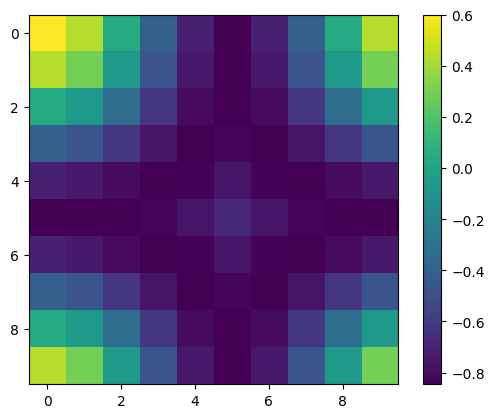

In [ ]:
im = plt.imshow(w[0, 0, :, :])
plt.colorbar(im)

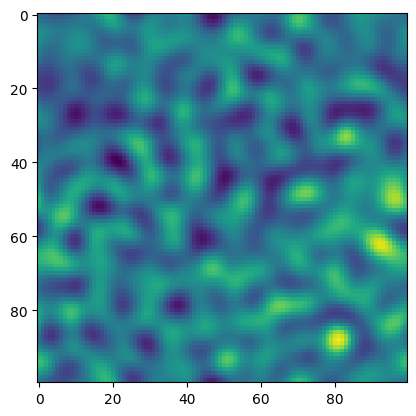

In [ ]:
attr = Attractor(create_ricker_matrix(100, 100, 4) - .4)

plt.imshow(attr(1 + .1*np.random.random((100, 100))).values())

In [ ]:
class RingAttractorState:
    def __init__(
        self,
        kernels: tuple[np.ndarray, ...],
        weights: tuple[np.ndarray, ...],
        indexer: AttractorIndexer,
        inplace: bool = False
    ):
        self.kernels = kernels
        self.weights = weights
        self.indexer = indexer
        self.inplace = inplace

    @property
    def shape(self) -> tuple[int, ...]:
        return self.kernels[0].shape

    @property
    def ndim(self) -> int:
        return self.kernels[0].ndim

    def __len__(self) -> int:
        return len(self.kernels)

    def __getitem__(self, indices: np.ndarray) -> tuple[np.ndarray, ...]:
        indices = wrap_indices(indices, self.shape)
        kernels = list(self.kernels)
        kernels = [kernels[-1]] + kernels[:-1]

        return tuple(select_data(weights, self.indexer[indices])*kernel[*indices] for weights, kernel in zip(self.weights, kernels))

    def __matmul__(self, other: tuple[np.ndarray, ...]) -> tuple[np.ndarray, ...]:
        if not self.inplace:
            other = tuple(inst.copy() for inst in other)

        for indices in zip(*np.nonzero(np.add(*self.kernels))):
            updates = self[indices]
            other = list(weight + update for weight, update in zip(other, updates))

        return other

    def values(self) -> np.ndarray:
        return self@tuple(np.zeros_like(weight) for weight in self.weights)


class RingAttractor:
    def __init__(
        self,
        kernels: tuple[np.ndarray, ...],
        inplace: bool = False
    ):
        self.kernels = kernels
        self.kernels_shifted = tuple(kernel[create_index_matrix(kernel.shape)] for kernel in kernels)
        self.indexer = AttractorIndexer(self.shape)
        self.inplace = inplace

    @property
    def shape(self) -> tuple[int, ...]:
        return self.kernels[0].shape

    @property
    def ndim(self) -> int:
        return self.kernels[0].ndim

    def __len__(self) -> int:
        return len(self.kernels)

    def __call__(self, weights: tuple[np.ndarray, ...]) -> RingAttractorState:
        if not self.inplace:
            weights = tuple(weight.copy() for weight in weights)
        return RingAttractorState(self.kernels_shifted, weights, self.indexer, self.inplace)

    def get_weights(self) -> tuple[np.ndarray, ...]:
        inverse_indexer = InverseAttractorIndexer(self.shape)

        weights_matrices = [np.zeros(list(self.shape) + list(self.shape)) for _ in range(len(self.kernels))]
        state = self([np.ones(self.shape) for _ in range(len(self.kernels))])

        for indices in zip(*np.nonzero(np.add(*self.kernels_shifted))):
            state_matrices = state[indices]
            for i in range(len(weights_matrices)):
                weights_matrices[i][*inverse_indexer[indices], *state.indexer[indices]] = state_matrices[i]

        weights_matrices = list(weights_matrices)

        return tuple([weights_matrices[-1]] + weights_matrices[:-1])


In [ ]:
attr = RingAttractor(
    (
        get_gaussian_kernel(100, .025, amplitude=1) - .4,
        # get_gaussian_kernel(n_hd_neurons, .025, amplitude=1, center=.55) - .4,
        get_gaussian_kernel(
            100,
            center=0.2,
            sigma=0.2
        ) + get_gaussian_kernel(
            100,
            center=0.8,
            sigma=0.2
        ),
        # 1 - get_gaussian_kernel(100, .025, amplitude=1) - .4,
    )
)

In [ ]:
weights = attr.get_weights()

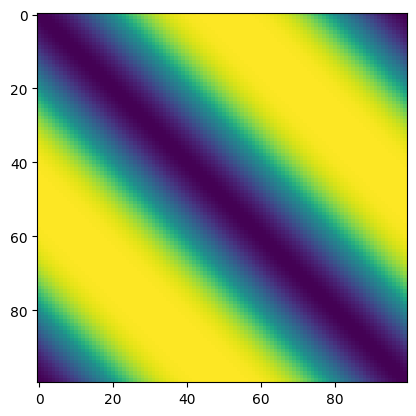

In [ ]:
plt.imshow(weights[0])

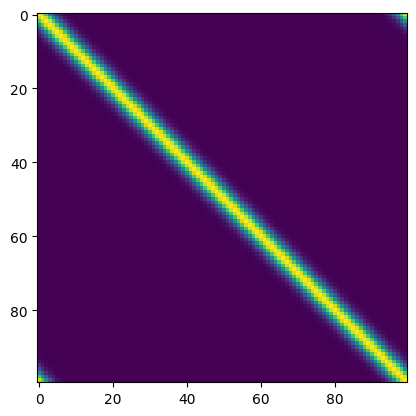

In [ ]:
plt.imshow(weights[1])

In [ ]:
def random_like(array: np.ndarray) -> np.ndarray:
    return np.random.rand(*array.shape)

In [ ]:
weights_ex, weights_inh = weights

In [ ]:
random_input = 10 + 0.05*(2*(random_like((1, 100))) - .5)

k_inh = (
    -act_inh + weights_inh@random_input.T
)



AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
w = np.random.random((1, attr.kernels[0].shape[-1])), np.random.random((1, attr.kernels[0].shape[-1]))#, np.random.random((1, attr.kernels[0].shape[-1]))
res = tuple(
    (weight@w_.T).T
    for weight, w_ in zip(weights, [w[0], w[1]])
)

In [ ]:
weight1, weight2 = weights
w_1, w_2 = w

In [ ]:
(weight1@(w_2).T).T

array([[-17.15424657, -16.91755473, -16.74008064, -16.65300191,
        -16.64657967, -16.68162262, -16.71133366, -16.70323999,
        -16.65525412, -16.59776114, -16.57517075, -16.6160313 ,
        -16.71495511, -16.83995465, -16.9541405 , -17.03215226,
        -17.06651153, -17.07039192, -17.0744636 , -17.10825493,
        -17.1724006 , -17.22731715, -17.21493103, -17.09978249,
        -16.89712231, -16.66554286, -16.47067666, -16.35055583,
        -16.30968217, -16.33920419, -16.43559895, -16.59641826,
        -16.79985672, -16.99387483, -17.11254618, -17.1119403 ,
        -16.99879857, -16.8284153 , -16.67084379, -16.569827  ,
        -16.5263464 , -16.51845343, -16.53561609, -16.5917201 ,
        -16.70261183, -16.85083306, -16.97612903, -17.00946747,
        -16.9263282 , -16.77011507, -16.62000077, -16.53227942,
        -16.51022176, -16.52406765, -16.55219103, -16.60261458,
        -16.70106875, -16.86050777, -17.05706595, -17.23119965,
        -17.31579962, -17.27401162, -17.

In [ ]:
(weight2@(w_1).T).T

array([[53.69598449, 53.68141968, 53.66423895, 53.65310576, 53.6420071 ,
        53.6276858 , 53.61552353, 53.60294196, 53.58890448, 53.58007648,
        53.57855653, 53.57751591, 53.58408578, 53.5945993 , 53.60926934,
        53.62266835, 53.64125561, 53.67179993, 53.71108402, 53.74821538,
        53.78862809, 53.83461211, 53.88714564, 53.94242718, 54.00402802,
        54.06690828, 54.13009632, 54.19555819, 54.26682704, 54.34157196,
        54.4164259 , 54.49776554, 54.58586922, 54.67005255, 54.74956597,
        54.82685641, 54.9050136 , 54.97767553, 55.04197087, 55.09839404,
        55.15208518, 55.19050362, 55.21862341, 55.23768404, 55.25180147,
        55.26215647, 55.26467557, 55.26106351, 55.24794852, 55.2268582 ,
        55.20550018, 55.17823568, 55.13960649, 55.10064562, 55.05041854,
        54.99248555, 54.92262858, 54.85522005, 54.78787298, 54.7150094 ,
        54.64448369, 54.57288593, 54.50475142, 54.43718328, 54.37371571,
        54.30598852, 54.23835212, 54.16799658, 54.0

In [ ]:
attr(w).values()[0]

array([[53.69598449, 53.68141968, 53.66423895, 53.65310576, 53.6420071 ,
        53.6276858 , 53.61552353, 53.60294196, 53.58890448, 53.58007648,
        53.57855653, 53.57751591, 53.58408578, 53.5945993 , 53.60926934,
        53.62266835, 53.64125561, 53.67179993, 53.71108402, 53.74821538,
        53.78862809, 53.83461211, 53.88714564, 53.94242718, 54.00402802,
        54.06690828, 54.13009632, 54.19555819, 54.26682704, 54.34157196,
        54.4164259 , 54.49776554, 54.58586922, 54.67005255, 54.74956597,
        54.82685641, 54.9050136 , 54.97767553, 55.04197087, 55.09839404,
        55.15208518, 55.19050362, 55.21862341, 55.23768404, 55.25180147,
        55.26215647, 55.26467557, 55.26106351, 55.24794852, 55.2268582 ,
        55.20550018, 55.17823568, 55.13960649, 55.10064562, 55.05041854,
        54.99248555, 54.92262858, 54.85522005, 54.78787298, 54.7150094 ,
        54.64448369, 54.57288593, 54.50475142, 54.43718328, 54.37371571,
        54.30598852, 54.23835212, 54.16799658, 54.0

In [ ]:
attr = RingAttractor((
    create_ricker_matrix(100, 100, 8),
    # create_gaussian_matrix(*all_data[0].shape[-2:], 4),
    create_ricker_matrix(100, 100, 2),
))

In [ ]:
w = attr.get_weights()

KeyboardInterrupt: 

In [ ]:
w[0].shape

(100, 100, 100, 100)

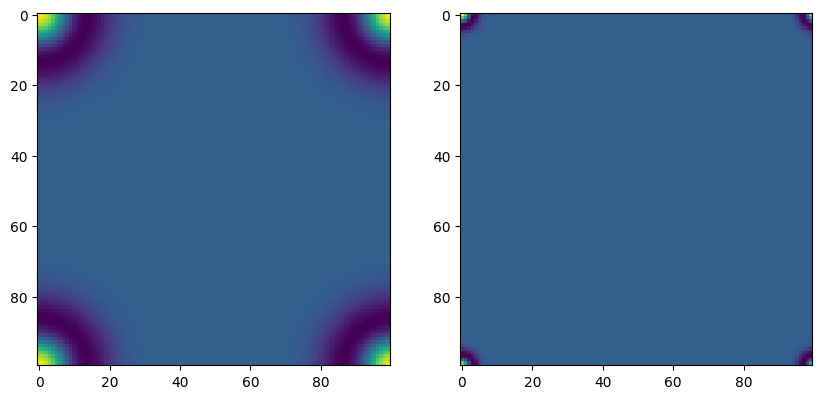

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(w[0][0, 0])
ax2.imshow(w[1][0, 0])